In [1]:
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

import joblib

import shap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier

from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.feature_selection import mutual_info_classif

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif, RFE

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, auc


In [2]:
df = pd.read_csv("C:/Users/kisha/Documents/Uni-Stuff/Dissertation/books/git/data_cleaned_no_weight.csv")
X = df.drop(columns=['Winner'])
y= df['Winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.45, random_state=42)

#oversampling minority class
smote = SMOTE(sampling_strategy='minority')
X_train, y_train = smote.fit_resample(X_train, y_train)



In [3]:
X_train_proper, X_calibration, y_train_proper, y_calibration = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_proper_scaled = scaler.fit_transform(X_train_proper)
X_calibration_scaled = scaler.transform(X_calibration)
X_test_scaled = scaler.transform(X_test)

In [4]:
best_lr = joblib.load("savedModels/best_model_lr.pkl")
best_rf = joblib.load("savedModels/best_model_rf.pkl")
best_xgb = joblib.load("savedModels/best_model_xgb.pkl")
best_deep = torch.load("savedModels/deep_model.pth")
best_ensemble = joblib.load("savedModels/voting_clf.pkl")

In [5]:
best_lr.fit(X_train_proper_scaled, y_train_proper)
calibration_probs_lr = best_lr.predict_proba(X_calibration_scaled)
nonconformity_scores_lr = 1 - calibration_probs_lr[np.arange(len(y_calibration)), y_calibration]

confidence_level = 0.90

q_hat_lr = np.quantile(nonconformity_scores_lr, confidence_level)

test_probs_lr = best_lr.predict_proba(X_test_scaled)
prediction_sets_lr = [np.where(probs >= (1 - q_hat_lr))[0] for probs in test_probs_lr]

coverage_lr = np.mean([y_test.iloc[i] in prediction_set for i, prediction_set in enumerate(prediction_sets_lr)])
print(f"Coverage of the prediction sets (Logistic Regression): {coverage_lr:.2f}")

for i, pred_set in enumerate(prediction_sets_lr[:50]):
    print(f"Instance {i} - True label: {y_test.iloc[i]}, Prediction set: {pred_set}")


Coverage of the prediction sets (Logistic Regression): 0.87
Instance 0 - True label: 1, Prediction set: [0 1]
Instance 1 - True label: 0, Prediction set: [0]
Instance 2 - True label: 1, Prediction set: [0]
Instance 3 - True label: 1, Prediction set: [0]
Instance 4 - True label: 0, Prediction set: [0]
Instance 5 - True label: 1, Prediction set: [0 1]
Instance 6 - True label: 0, Prediction set: [0 1]
Instance 7 - True label: 1, Prediction set: [1]
Instance 8 - True label: 0, Prediction set: [0]
Instance 9 - True label: 0, Prediction set: [0]
Instance 10 - True label: 1, Prediction set: [0 1]
Instance 11 - True label: 0, Prediction set: [0 1]
Instance 12 - True label: 1, Prediction set: [0]
Instance 13 - True label: 1, Prediction set: [0 1]
Instance 14 - True label: 1, Prediction set: [0 1]
Instance 15 - True label: 0, Prediction set: [0]
Instance 16 - True label: 0, Prediction set: [0]
Instance 17 - True label: 1, Prediction set: [0]
Instance 18 - True label: 0, Prediction set: [1]
Insta

In [6]:
best_rf.fit(X_train_proper_scaled, y_train_proper)
calibration_probs_rf = best_rf.predict_proba(X_calibration_scaled)
nonconformity_scores_rf = 1 - calibration_probs_rf[np.arange(len(y_calibration)), y_calibration]

q_hat_rf = np.quantile(nonconformity_scores_rf, confidence_level)

test_probs_rf = best_rf.predict_proba(X_test_scaled)
prediction_sets_rf = [np.where(probs >= (1 - q_hat_rf))[0] for probs in test_probs_rf]

coverage_rf = np.mean([y_test.iloc[i] in prediction_set for i, prediction_set in enumerate(prediction_sets_rf)])
print(f"Coverage of the prediction sets (Random Forest): {coverage_rf:.2f}")

for i, pred_set in enumerate(prediction_sets_rf[:50]):
    print(f"Instance {i} - True label: {y_test.iloc[i]}, Prediction set: {pred_set}")

Coverage of the prediction sets (Random Forest): 0.82
Instance 0 - True label: 1, Prediction set: [1]
Instance 1 - True label: 0, Prediction set: [0]
Instance 2 - True label: 1, Prediction set: [0]
Instance 3 - True label: 1, Prediction set: [0]
Instance 4 - True label: 0, Prediction set: [0]
Instance 5 - True label: 1, Prediction set: [0 1]
Instance 6 - True label: 0, Prediction set: [0]
Instance 7 - True label: 1, Prediction set: [0 1]
Instance 8 - True label: 0, Prediction set: [0]
Instance 9 - True label: 0, Prediction set: [0]
Instance 10 - True label: 1, Prediction set: [0]
Instance 11 - True label: 0, Prediction set: [0]
Instance 12 - True label: 1, Prediction set: [0 1]
Instance 13 - True label: 1, Prediction set: [0 1]
Instance 14 - True label: 1, Prediction set: [0 1]
Instance 15 - True label: 0, Prediction set: [0]
Instance 16 - True label: 0, Prediction set: [0]
Instance 17 - True label: 1, Prediction set: [0]
Instance 18 - True label: 0, Prediction set: [0 1]
Instance 19 -

In [7]:
best_xgb.fit(X_train_proper_scaled, y_train_proper)
calibration_probs_xgb = best_xgb.predict_proba(X_calibration_scaled)
nonconformity_scores_xgb = 1 - calibration_probs_xgb[np.arange(len(y_calibration)), y_calibration]

q_hat_xgb = np.quantile(nonconformity_scores_xgb, confidence_level)

test_probs_xgb = best_xgb.predict_proba(X_test_scaled)
prediction_sets_xgb = [np.where(probs >= (1 - q_hat_xgb))[0] for probs in test_probs_xgb]

coverage_xgb = np.mean([y_test.iloc[i] in prediction_set for i, prediction_set in enumerate(prediction_sets_xgb)])
print(f"Coverage of the prediction sets (XGBoost): {coverage_xgb:.2f}")

for i, pred_set in enumerate(prediction_sets_xgb[:50]):
    print(f"Instance {i} - True label: {y_test.iloc[i]}, Prediction set: {pred_set}")


Coverage of the prediction sets (XGBoost): 0.84
Instance 0 - True label: 1, Prediction set: [1]
Instance 1 - True label: 0, Prediction set: [0]
Instance 2 - True label: 1, Prediction set: [0]
Instance 3 - True label: 1, Prediction set: [0]
Instance 4 - True label: 0, Prediction set: [0]
Instance 5 - True label: 1, Prediction set: [0 1]
Instance 6 - True label: 0, Prediction set: [0 1]
Instance 7 - True label: 1, Prediction set: [1]
Instance 8 - True label: 0, Prediction set: [0]
Instance 9 - True label: 0, Prediction set: [0]
Instance 10 - True label: 1, Prediction set: [0 1]
Instance 11 - True label: 0, Prediction set: [0]
Instance 12 - True label: 1, Prediction set: [0 1]
Instance 13 - True label: 1, Prediction set: [0 1]
Instance 14 - True label: 1, Prediction set: [0 1]
Instance 15 - True label: 0, Prediction set: [0]
Instance 16 - True label: 0, Prediction set: [0]
Instance 17 - True label: 1, Prediction set: [0]
Instance 18 - True label: 0, Prediction set: [0 1]
Instance 19 - Tru

In [14]:
class SklearnWrapper(nn.Module):
    def __init__(self, model):
        super(SklearnWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

    def fit(self, X, y, epochs=50, batch_size=64, lr=0.001):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)
        dataset = TensorDataset(X_tensor, y_tensor)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        
        self.model.train()
        for epoch in range(epochs):
            accumulated_loss = 0.0
            for batch_features, batch_labels in loader:
                optimizer.zero_grad()
                batch_outputs = self.model(batch_features)
                batch_loss = criterion(batch_outputs, batch_labels)
                batch_loss.backward()
                optimizer.step()

                accumulated_loss += batch_loss.item() * batch_features.size(0)

            avg_epoch_loss = accumulated_loss / len(loader.dataset)
            print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss:.4f}')

    def predict_proba(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32)
            outputs = self.model(X_tensor)
            probs = outputs.numpy()
        return np.hstack([1 - probs, probs])

In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

train_features = torch.tensor(X_train, dtype=torch.float32)
train_labels = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Correct placement of unsqueeze
test_features = torch.tensor(X_test, dtype=torch.float32)

train_dataset_unique = TensorDataset(train_features, train_labels)
train_loader_unique = DataLoader(train_dataset_unique, batch_size=64, shuffle=True)

class DeepNet3(nn.Module):
    def __init__(self, input_dim):
        super(DeepNet3, self).__init__()
        self.layer1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.layer2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.layer3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.layer4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.layer5 = nn.Linear(32, 16)
        self.bn5 = nn.BatchNorm1d(16)
        self.output_layer = nn.Linear(16, 1)
        self.dropout = nn.Dropout(p=0.5)
        self.activation = nn.ReLU()
        self.output_activation = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout(self.activation(self.bn1(self.layer1(x))))
        x = self.dropout(self.activation(self.bn2(self.layer2(x))))
        x = self.dropout(self.activation(self.bn3(self.layer3(x))))
        x = self.dropout(self.activation(self.bn4(self.layer4(x))))
        x = self.dropout(self.activation(self.bn5(self.layer5(x))))
        x = self.output_activation(self.output_layer(x))
        return x

input_dim = 145
deep_model3 = DeepNet3(input_dim)

loss_function3 = nn.BCELoss()
optimizer3 = optim.Adam(deep_model3.parameters(), lr=0.001)

total_epochs = 50
deep_model3.train()
for epoch_num in range(total_epochs):
    accumulated_loss3 = 0.0
    for batch_features, batch_labels in train_loader_unique:
        batch_labels = batch_labels.view(-1,1)  # Remove extra dimensions if any
        optimizer3.zero_grad()
        batch_outputs = deep_model3(batch_features)
        batch_loss = loss_function3(batch_outputs, batch_labels)
        batch_loss.backward()
        optimizer3.step()

        accumulated_loss3 += batch_loss.item() * batch_features.size(0)

    avg_epoch_loss3 = accumulated_loss3 / len(train_loader_unique.dataset)
    print(f'Epoch {epoch_num+1}/{total_epochs}, Loss: {avg_epoch_loss3:.4f}')

deep_model3.eval()
with torch.no_grad():
    test_outputs3 = deep_model3(test_features)
    test_predictions3 = (test_outputs3.numpy() > 0.5).astype(int)



Epoch 1/50, Loss: 0.7136
Epoch 2/50, Loss: 0.6952
Epoch 3/50, Loss: 0.6814
Epoch 4/50, Loss: 0.6695
Epoch 5/50, Loss: 0.6472
Epoch 6/50, Loss: 0.6306
Epoch 7/50, Loss: 0.6240
Epoch 8/50, Loss: 0.5949
Epoch 9/50, Loss: 0.5911
Epoch 10/50, Loss: 0.5678
Epoch 11/50, Loss: 0.5594
Epoch 12/50, Loss: 0.5550
Epoch 13/50, Loss: 0.5510
Epoch 14/50, Loss: 0.5491
Epoch 15/50, Loss: 0.5317
Epoch 16/50, Loss: 0.5278
Epoch 17/50, Loss: 0.5273
Epoch 18/50, Loss: 0.5138
Epoch 19/50, Loss: 0.5094
Epoch 20/50, Loss: 0.5088
Epoch 21/50, Loss: 0.5043
Epoch 22/50, Loss: 0.5005
Epoch 23/50, Loss: 0.4871
Epoch 24/50, Loss: 0.4985
Epoch 25/50, Loss: 0.4970
Epoch 26/50, Loss: 0.4820
Epoch 27/50, Loss: 0.4855
Epoch 28/50, Loss: 0.4802
Epoch 29/50, Loss: 0.4746
Epoch 30/50, Loss: 0.4684
Epoch 31/50, Loss: 0.4650
Epoch 32/50, Loss: 0.4691
Epoch 33/50, Loss: 0.4553
Epoch 34/50, Loss: 0.4585
Epoch 35/50, Loss: 0.4507
Epoch 36/50, Loss: 0.4615
Epoch 37/50, Loss: 0.4536
Epoch 38/50, Loss: 0.4519
Epoch 39/50, Loss: 0.

In [16]:
model_wrapper = SklearnWrapper(deep_model3)
model_wrapper.fit(X_train_proper_scaled, y_train_proper)
calibration_probs_deep = model_wrapper.predict_proba(X_calibration_scaled)
nonconformity_scores_deep = 1 - calibration_probs_deep[np.arange(len(y_calibration)), y_calibration]

q_hat_deep = np.quantile(nonconformity_scores_deep, confidence_level)

test_probs_deep = model_wrapper.predict_proba(X_test_scaled)
prediction_sets_deep = [np.where(probs >= (1 - q_hat_deep))[0] for probs in test_probs_deep]

coverage_deep = np.mean([y_test.iloc[i] in prediction_set for i, prediction_set in enumerate(prediction_sets_deep)])
print(f"Coverage of the prediction sets (Deep Learning): {coverage_deep:.2f}")

for i, pred_set in enumerate(prediction_sets_deep[:50]):
    print(f"Instance {i} - True label: {y_test.iloc[i]}, Prediction set: {pred_set}")

Epoch 1/50, Loss: 0.4151
Epoch 2/50, Loss: 0.4058
Epoch 3/50, Loss: 0.4085
Epoch 4/50, Loss: 0.4147
Epoch 5/50, Loss: 0.3946
Epoch 6/50, Loss: 0.3973
Epoch 7/50, Loss: 0.3967
Epoch 8/50, Loss: 0.3971
Epoch 9/50, Loss: 0.3894
Epoch 10/50, Loss: 0.3971
Epoch 11/50, Loss: 0.3895
Epoch 12/50, Loss: 0.3783
Epoch 13/50, Loss: 0.3741
Epoch 14/50, Loss: 0.3758
Epoch 15/50, Loss: 0.3841
Epoch 16/50, Loss: 0.3774
Epoch 17/50, Loss: 0.3745
Epoch 18/50, Loss: 0.3782
Epoch 19/50, Loss: 0.3692
Epoch 20/50, Loss: 0.3690
Epoch 21/50, Loss: 0.3604
Epoch 22/50, Loss: 0.3463
Epoch 23/50, Loss: 0.3753
Epoch 24/50, Loss: 0.3614
Epoch 25/50, Loss: 0.3680
Epoch 26/50, Loss: 0.3821
Epoch 27/50, Loss: 0.3753
Epoch 28/50, Loss: 0.3815
Epoch 29/50, Loss: 0.3692
Epoch 30/50, Loss: 0.3730
Epoch 31/50, Loss: 0.3699
Epoch 32/50, Loss: 0.3570
Epoch 33/50, Loss: 0.3435
Epoch 34/50, Loss: 0.3449
Epoch 35/50, Loss: 0.3420
Epoch 36/50, Loss: 0.3385
Epoch 37/50, Loss: 0.3362
Epoch 38/50, Loss: 0.3355
Epoch 39/50, Loss: 0.

In [17]:
best_ensemble.fit(X_train_proper_scaled, y_train_proper)
calibration_probs_ensemble = best_ensemble.predict_proba(X_calibration_scaled)
nonconformity_scores_ensemble = 1 - calibration_probs_ensemble[np.arange(len(y_calibration)), y_calibration]

q_hat_ensemble = np.quantile(nonconformity_scores_ensemble, confidence_level)

test_probs_ensemble = best_ensemble.predict_proba(X_test_scaled)
prediction_sets_ensemble = [np.where(probs >= (1 - q_hat_ensemble))[0] for probs in test_probs_ensemble]

coverage_ensemble = np.mean([y_test.iloc[i] in prediction_set for i, prediction_set in enumerate(prediction_sets_ensemble)])
print(f"Coverage of the prediction sets (Ensemble): {coverage_ensemble:.2f}")

for i, pred_set in enumerate(prediction_sets_ensemble[:50]):
    print(f"Instance {i} - True label: {y_test.iloc[i]}, Prediction set: {pred_set}")

Coverage of the prediction sets (Ensemble): 0.85
Instance 0 - True label: 1, Prediction set: [1]
Instance 1 - True label: 0, Prediction set: [0]
Instance 2 - True label: 1, Prediction set: [0 1]
Instance 3 - True label: 1, Prediction set: [0]
Instance 4 - True label: 0, Prediction set: [0]
Instance 5 - True label: 1, Prediction set: [0 1]
Instance 6 - True label: 0, Prediction set: [0 1]
Instance 7 - True label: 1, Prediction set: [1]
Instance 8 - True label: 0, Prediction set: [0 1]
Instance 9 - True label: 0, Prediction set: [0 1]
Instance 10 - True label: 1, Prediction set: [0 1]
Instance 11 - True label: 0, Prediction set: [0]
Instance 12 - True label: 1, Prediction set: [0 1]
Instance 13 - True label: 1, Prediction set: [0 1]
Instance 14 - True label: 1, Prediction set: [0]
Instance 15 - True label: 0, Prediction set: [0]
Instance 16 - True label: 0, Prediction set: [0]
Instance 17 - True label: 1, Prediction set: [0]
Instance 18 - True label: 0, Prediction set: [1]
Instance 19 - 

In [28]:
print(f"Coverage of the prediction sets (Logistic Regression): {coverage_lr:.2f}")
print(f"Coverage of the prediction sets (Random Forest): {coverage_rf:.2f}")
print(f"Coverage of the prediction sets (XGBoost): {coverage_xgb:.2f}")
print(f"Coverage of the prediction sets (Deep Learning): {coverage_deep:.2f}")
print(f"Coverage of the prediction sets (Ensemble): {coverage_ensemble:.2f}")


Coverage of the prediction sets (Logistic Regression): 0.87
Coverage of the prediction sets (Random Forest): 0.82
Coverage of the prediction sets (XGBoost): 0.84
Coverage of the prediction sets (Deep Learning): 0.81
Coverage of the prediction sets (Ensemble): 0.85


In [18]:
coverages = {
    "Logistic Regression": coverage_lr,
    "Random Forest": coverage_rf,
    "XGBoost": coverage_xgb,
    "Deep Learning": coverage_deep,
    "Ensemble": coverage_ensemble
}

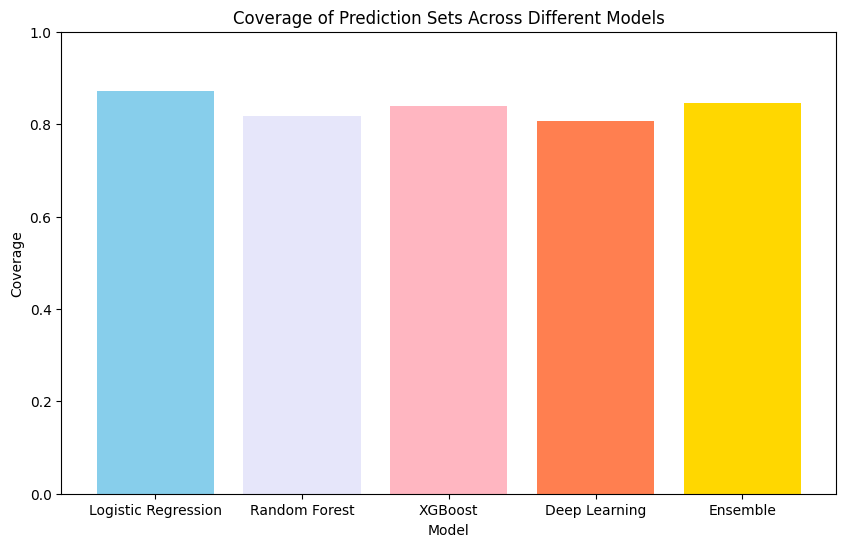

In [36]:
plt.figure(figsize=(10, 6))
plt.bar(coverages.keys(), 
        coverages.values(), 
        color=['skyblue', 'lavender', 'lightpink', 'coral', 'gold'])

plt.title('Coverage of Prediction Sets Across Different Models')
plt.xlabel('Model')
plt.ylabel('Coverage')
plt.ylim(0, 1) 
plt.show()